In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns


df = pd.read_csv('data.csv')

# print(df.head())

df = df.set_index('Date')

feature_columns = ['VIX_log','Overnight Rate','1-Month Rate','3-Month Rate','CPI_pct_change','PPI_pct_change','Unemployment Rate','GDP_pct_change']
target_column = 'SPY_vol_5d'
# target_column = "SPY_log_return"
df = df[feature_columns + [target_column]]
df = df.dropna()

X = df[feature_columns]
y = df[target_column]

print(X.isna().sum())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(len(X_scaled))

VIX_log              0
Overnight Rate       0
1-Month Rate         0
3-Month Rate         0
CPI_pct_change       0
PPI_pct_change       0
Unemployment Rate    0
GDP_pct_change       0
dtype: int64
1226


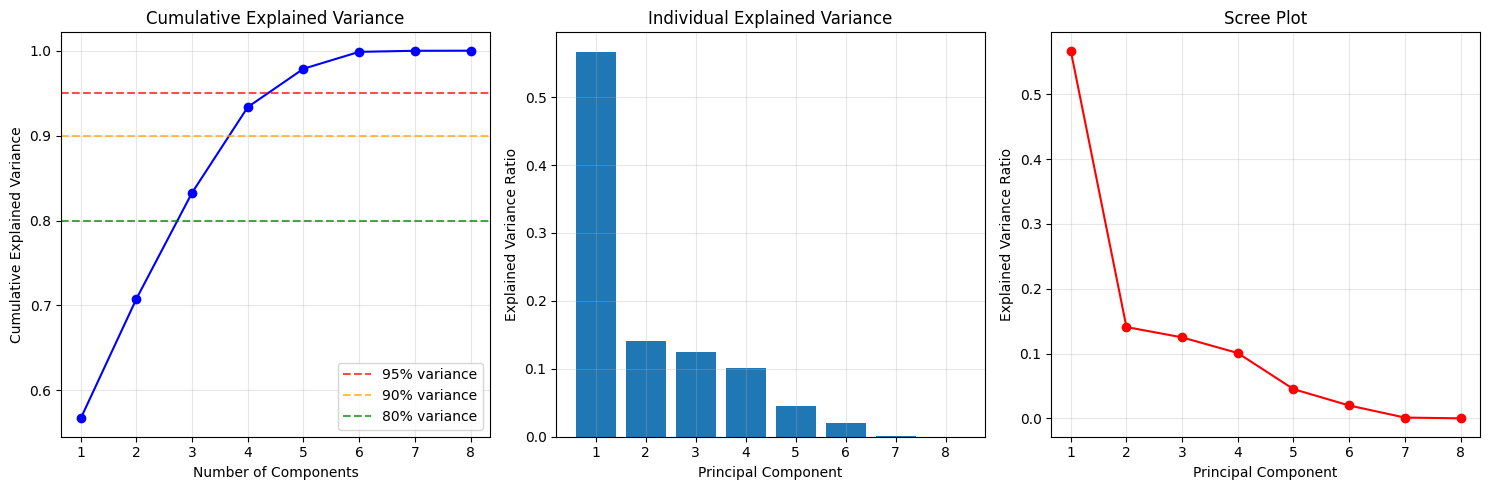


Optimal number of components:
80% variance: 3 components
90% variance: 4 components
95% variance: 5 components
99% variance: 6 components

Selected number of components: 5


In [2]:
# Perform PCA with all components to analyze variance
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(15, 5))

# Cumulative explained variance
plt.subplot(1, 3, 1)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
plt.axhline(y=0.80, color='green', linestyle='--', alpha=0.7, label='80% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

# Individual explained variance
plt.subplot(1, 3, 2)
components = range(1, len(pca_full.explained_variance_ratio_) + 1)
plt.bar(components, pca_full.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance')
plt.grid(True, alpha=0.3)

# Scree plot
plt.subplot(1, 3, 3)
plt.plot(components, pca_full.explained_variance_ratio_, 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal number of components
variance_thresholds = [0.80, 0.90, 0.95, 0.99]
print("\nOptimal number of components:")
for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"{threshold:.0%} variance: {n_components} components")

# Choose number of components
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nSelected number of components: {optimal_components}")

In [3]:
optimal_components = 5 
# Perform PCA with optimal number of components
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA completed with {optimal_components} components")
print(f"Original shape: {X.shape}")
print(f"PCA shape: {X_pca.shape}")
print(f"Total variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")

# Create DataFrame for PCA results with preserved index
pca_columns = [f'PC{i+1}' for i in range(optimal_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_columns, index=X.index)  # Preserve the original index
df_pca[target_column] = y.values

print("\nPCA Results DataFrame:")
print(len(df_pca))
print("Index preserved:", df_pca.index.name)
print("First few rows with index:")
print(df_pca.head())
df_pca.to_csv('data/pca_data_with_both.csv', index=True)

PCA completed with 5 components
Original shape: (1226, 8)
PCA shape: (1226, 5)
Total variance explained: 0.979

PCA Results DataFrame:
1226
Index preserved: Date
First few rows with index:
                 PC1       PC2       PC3       PC4       PC5  SPY_vol_5d
Date                                                                    
2021-01-11 -1.795039  4.216693  1.162123 -0.687972 -0.494186    0.019447
2021-01-12 -1.791159  4.079792 -0.711020 -0.718029 -0.498380    0.018196
2021-01-13 -1.788438  4.062135 -0.942270 -0.720900 -0.497934    0.017402
2021-01-14 -1.793319  4.154452  0.308703 -0.701645 -0.495910    0.009879
2021-01-15 -1.791090  4.153780  0.309440 -0.700788 -0.494902    0.010904


PCA Component Loadings (Feature Weights):
                      PC1     PC2     PC3     PC4     PC5
VIX_log           -0.0021  0.0730  0.9970  0.0160  0.0024
Overnight Rate     0.4480 -0.0656  0.0007  0.2065  0.3505
1-Month Rate       0.4527 -0.1018  0.0039  0.1868  0.2850
3-Month Rate       0.4531 -0.1469  0.0067  0.1717  0.2043
CPI_pct_change    -0.3500 -0.4603  0.0141  0.3917 -0.0348
PPI_pct_change    -0.3366 -0.0393  0.0004  0.7223  0.1718
Unemployment Rate -0.2828  0.6534 -0.0556  0.0033  0.6167
GDP_pct_change    -0.2707 -0.5640  0.0505 -0.4665  0.5857


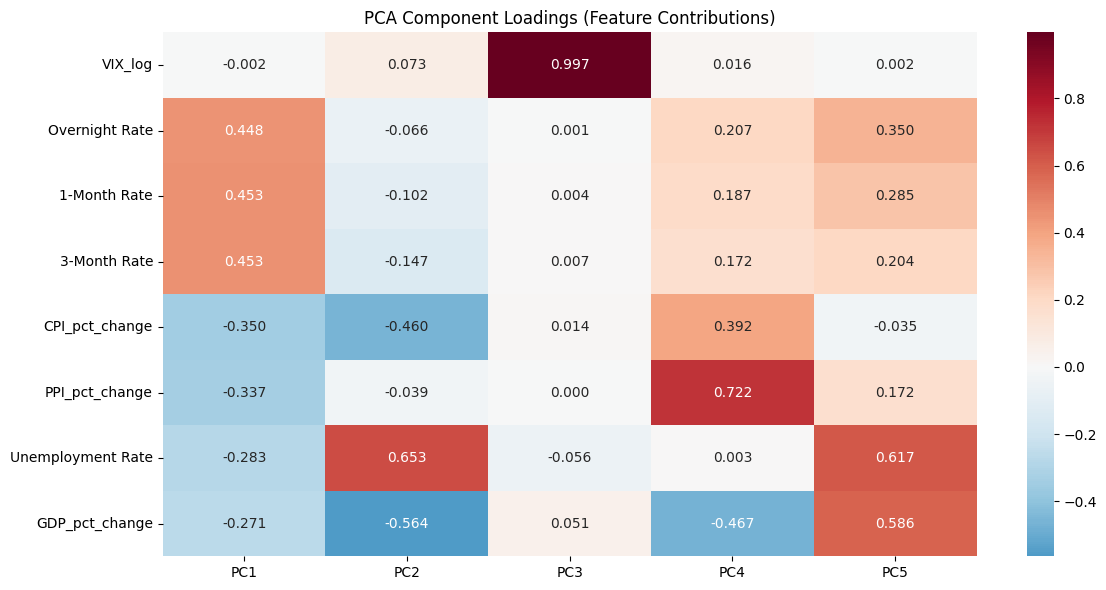


Top features for each principal component:

PC1:
  3-Month Rate: 0.4531
  1-Month Rate: 0.4527
  Overnight Rate: 0.4480

PC2:
  Unemployment Rate: 0.6534
  GDP_pct_change: 0.5640
  CPI_pct_change: 0.4603

PC3:
  VIX_log: 0.9970
  Unemployment Rate: 0.0556
  GDP_pct_change: 0.0505

PC4:
  PPI_pct_change: 0.7223
  GDP_pct_change: 0.4665
  CPI_pct_change: 0.3917

PC5:
  Unemployment Rate: 0.6167
  GDP_pct_change: 0.5857
  Overnight Rate: 0.3505


In [4]:
# Component analysis
components_df = pd.DataFrame(
    pca.components_.T,
    columns=pca_columns,
    index=feature_columns
)

print("PCA Component Loadings (Feature Weights):")
print(components_df.round(4))

# Visualize component loadings
plt.figure(figsize=(12, 6))
sns.heatmap(components_df, annot=True, cmap='RdBu_r', center=0, fmt='.3f')
plt.title('PCA Component Loadings (Feature Contributions)')
plt.tight_layout()
plt.show()

# Analyze which features contribute most to each component
print("\nTop features for each principal component:")
for i, pc in enumerate(pca_columns):
    component_loadings = components_df[pc].abs().sort_values(ascending=False)
    print(f"\n{pc}:")
    for feature, loading in component_loadings.head(3).items():
        print(f"  {feature}: {loading:.4f}")

Correlation between PCA components and SPY returns:
PC4   -0.0111
PC3   -0.0305
PC1   -0.0809
PC2   -0.2073
PC5   -0.2876
Name: SPY_vol_5d, dtype: float64


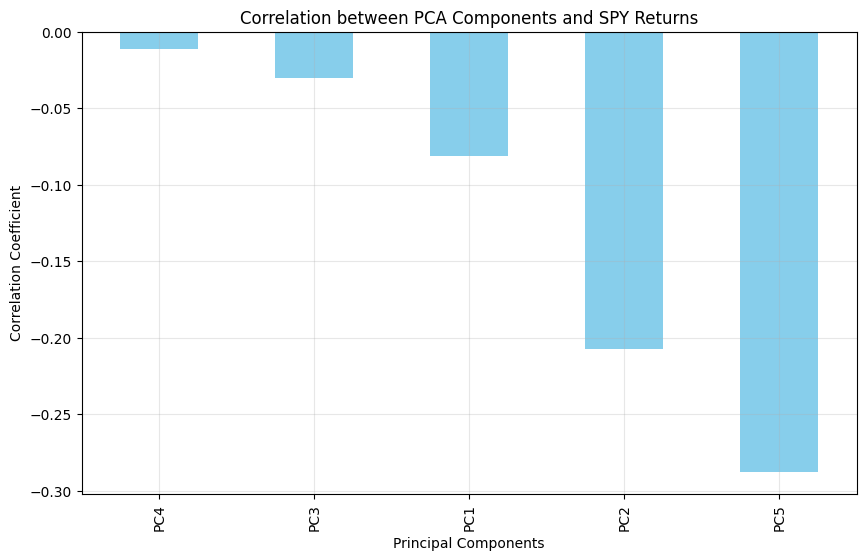

In [5]:
# Check correlation between PCA components and target
pca_target_corr = df_pca.corr()[target_column].drop(target_column).sort_values(ascending=False)

print("Correlation between PCA components and SPY returns:")
print(pca_target_corr.round(4))

# Plot correlation with target
plt.figure(figsize=(10, 6))
pca_target_corr.plot(kind='bar', color='skyblue')
plt.title('Correlation between PCA Components and SPY Returns')
plt.xlabel('Principal Components')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.cumsum())


Original shape: (1226, 8)
Reduced shape: (1226, 5)
Explained variance ratio: [0.56702932 0.14087474 0.12495279 0.1007723  0.04512549]
Cumulative variance explained: [0.56702932 0.70790406 0.83285685 0.93362915 0.97875464]


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

# Train model on PCA components
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(y_pred)

print(f"\nModel Performance on PCA Components:")
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.4f}")

# Compare with original features
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
model_orig = RandomForestRegressor(n_estimators=100, random_state=42)
model_orig.fit(X_orig_train, y_orig_train)
y_orig_pred = model_orig.predict(X_orig_test)
r2_orig = r2_score(y_orig_test, y_orig_pred)

print(f"R² Score with original features: {r2_orig:.4f}")
print(f"PCA performance vs original: {r2/r2_orig:.2%}")


Model Performance on PCA Components:
Mean Squared Error: 0.000060
R² Score: 0.4878
R² Score with original features: 0.6398
PCA performance vs original: 76.24%


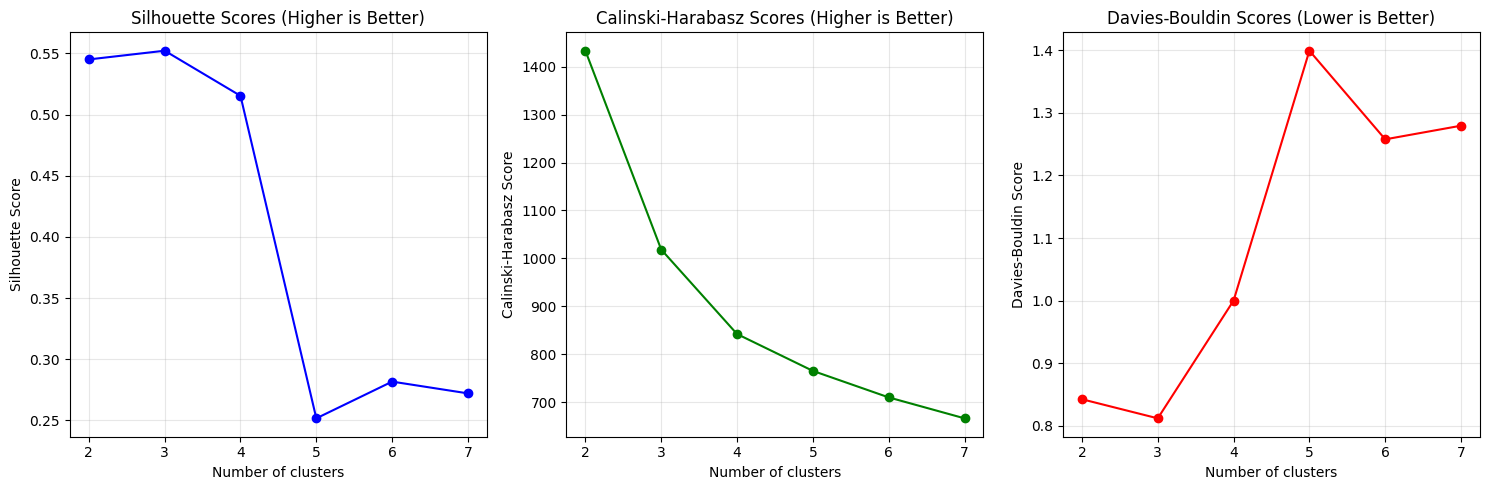

Best k by Silhouette Score: 3 (score = 0.552)
Best k by Calinski-Harabasz: 2 (score = 1433.0)
Best k by Davies-Bouldin: 3 (score = 0.812)

Selected best k = 3 (most common among metrics)

Scores for k=3:
  Silhouette Score: 0.552
  Calinski-Harabasz Score: 1018.5
  Davies-Bouldin Score: 0.812


In [8]:
# Find best k with multiple clustering metrics
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

scores_silhouette = []
scores_ch = []
scores_db = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    
    # Calculate multiple metrics
    sil_score = silhouette_score(X_pca, labels)
    ch_score = calinski_harabasz_score(X_pca, labels)
    db_score = davies_bouldin_score(X_pca, labels)
    
    scores_silhouette.append(sil_score)
    scores_ch.append(ch_score)
    scores_db.append(db_score)

# Plot all metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Silhouette scores (higher is better)
axes[0].plot(K_range, scores_silhouette, marker='o', color='blue')
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Scores (Higher is Better)")
axes[0].grid(True, alpha=0.3)

# Calinski-Harabasz scores (higher is better)
axes[1].plot(K_range, scores_ch, marker='o', color='green')
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Calinski-Harabasz Score")
axes[1].set_title("Calinski-Harabasz Scores (Higher is Better)")
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin scores (lower is better)
axes[2].plot(K_range, scores_db, marker='o', color='red')
axes[2].set_xlabel("Number of clusters")
axes[2].set_ylabel("Davies-Bouldin Score")
axes[2].set_title("Davies-Bouldin Scores (Lower is Better)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best k for each metric
best_k_sil = K_range[scores_silhouette.index(max(scores_silhouette))]
best_k_ch = K_range[scores_ch.index(max(scores_ch))]
best_k_db = K_range[scores_db.index(min(scores_db))]

print(f"Best k by Silhouette Score: {best_k_sil} (score = {max(scores_silhouette):.3f})")
print(f"Best k by Calinski-Harabasz: {best_k_ch} (score = {max(scores_ch):.1f})")
print(f"Best k by Davies-Bouldin: {best_k_db} (score = {min(scores_db):.3f})")

# Choose the most common best k or use silhouette as tiebreaker
best_k_candidates = [best_k_sil, best_k_ch, best_k_db]
from collections import Counter
most_common = Counter(best_k_candidates).most_common(1)[0][0]
best_k = most_common

print(f"\nSelected best k = {best_k} (most common among metrics)")

# Display all scores for the selected k
k_idx = K_range.index(best_k)
print(f"\nScores for k={best_k}:")
print(f"  Silhouette Score: {scores_silhouette[k_idx]:.3f}")
print(f"  Calinski-Harabasz Score: {scores_ch[k_idx]:.1f}")
print(f"  Davies-Bouldin Score: {scores_db[k_idx]:.3f}")

Silhouette Score on PCA data: 0.5521637474341856


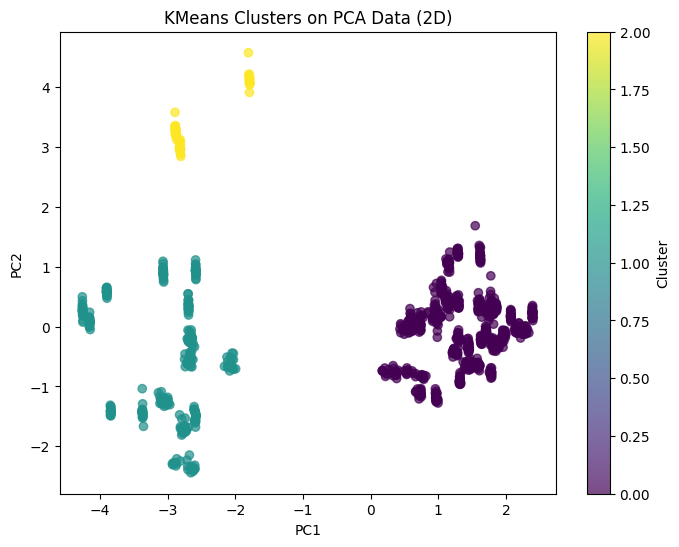

In [9]:
#CLUSTERS on pca data

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

score = silhouette_score(X_pca, labels)
print("Silhouette Score on PCA data:", score)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters on PCA Data (2D)")
plt.colorbar(label="Cluster")
plt.show()

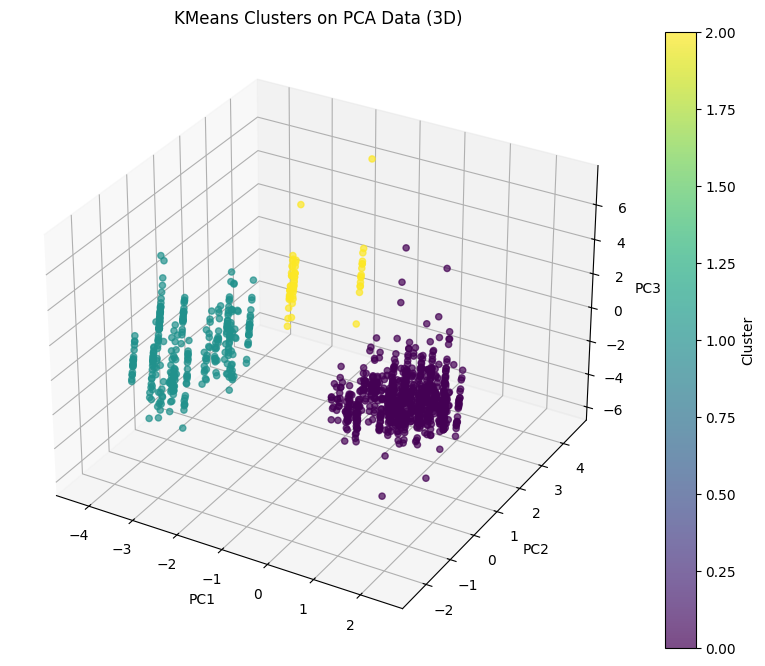

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels, cmap='viridis', alpha=0.7
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("KMeans Clusters on PCA Data (3D)")

# Add colorbar
fig.colorbar(scatter, ax=ax, label="Cluster")

plt.show()

In [11]:
# Create cluster dataframe with target variable and preserved index
df_clusters = X.copy()
df_clusters['cluster'] = labels
df_clusters['SPY_vol_5d'] = y

# Cluster sizes
value_counts = df_clusters['cluster'].value_counts()
print("Cluster sizes:")
print(value_counts)

# Average of each feature per cluster including target mean
centroids = df_clusters.groupby('cluster').mean()
print("\nCentroids (including target mean):")
print(centroids)

print("\nFull cluster dataframe with preserved index:")
print(df_clusters.head())
print(f"Index name: {df_clusters.index.name}")
print(f"Index type: {type(df_clusters.index)}")


Cluster sizes:
cluster
0    838
1    330
2     58
Name: count, dtype: int64

Centroids (including target mean):
          VIX_log  Overnight Rate  1-Month Rate  3-Month Rate  CPI_pct_change   
cluster                                                                         
0       -0.074639        4.584212      4.582434      4.575263        0.240698  \
1        0.118780        0.227727      0.303242      0.476394        0.724113   
2       -0.182012        0.078621      0.048448      0.064483        0.314304   

         PPI_pct_change  Unemployment Rate  GDP_pct_change  SPY_vol_5d  
cluster                                                                 
0             -0.163794           3.858473        1.306754    0.019834  
1              1.777721           4.534848        2.663216    0.022077  
2              1.805066           6.212069        0.000000    0.019670  

Full cluster dataframe with preserved index:
              VIX_log  Overnight Rate  1-Month Rate  3-Month Rate   
Da

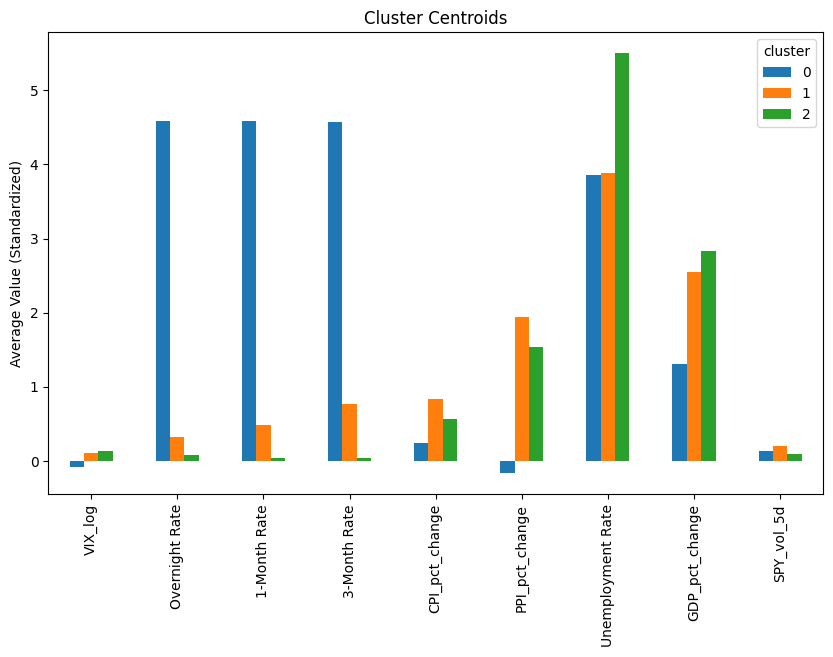

In [16]:
import matplotlib.pyplot as plt

centroids.T.plot(kind='bar', figsize=(10,6))
plt.title("Cluster Centroids")
plt.ylabel("Average Value (Standardized)")
plt.show()


In [13]:
# Export cluster data with Date index preserved
cluster_long = df_clusters[['cluster']].copy()
# cluster_long.to_csv("cluster_long.csv", index=True)

print("Cluster data exported with Date index preserved:")
print(cluster_long.head())

Cluster data exported with Date index preserved:
            cluster
Date               
2021-01-11        2
2021-01-12        2
2021-01-13        2
2021-01-14        2
2021-01-15        2


DBSCAN Parameter Testing:
eps=0.2, min_samples= 3: clusters=122, noise=315, sil=0.517, ch=807.1, db=0.512
eps=0.3, min_samples= 3: clusters=89, noise=189, sil=0.414, ch=527.5, db=0.729
eps=0.3, min_samples= 5: clusters=58, noise=356, sil=0.443, ch=690.2, db=0.783
eps=0.4, min_samples= 3: clusters=65, noise=110, sil=0.297, ch=355.9, db=1.034
eps=0.4, min_samples= 5: clusters=55, noise=209, sil=0.342, ch=498.7, db=0.991
eps=0.4, min_samples=10: clusters=34, noise=535, sil=0.445, ch=635.1, db=0.778
eps=0.5, min_samples= 3: clusters=51, noise= 77, sil=0.290, ch=337.4, db=1.029
eps=0.5, min_samples= 5: clusters=38, noise=145, sil=0.330, ch=454.1, db=1.104
eps=0.5, min_samples=10: clusters=31, noise=365, sil=0.383, ch=581.7, db=0.889
eps=0.6, min_samples= 3: clusters=34, noise= 50, sil=0.212, ch=307.8, db=1.050
eps=0.6, min_samples= 5: clusters=29, noise= 92, sil=0.252, ch=366.6, db=1.066
eps=0.6, min_samples=10: clusters=25, noise=206, sil=0.268, ch=404.8, db=0.958
eps=0.6, min_samples=15: 

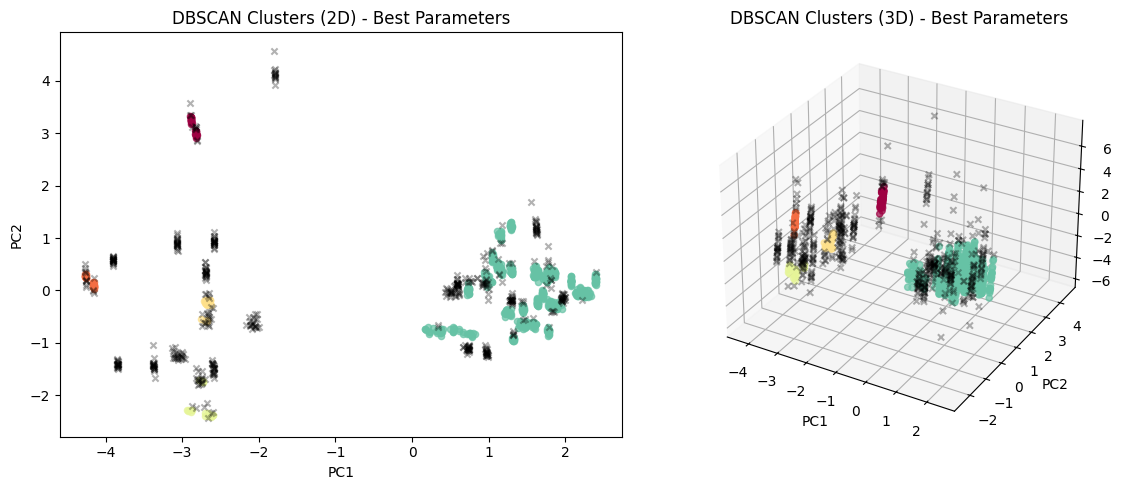


Best DBSCAN Results:
Number of clusters: 5
Number of noise points: 518
Noise percentage: 42.3%

Best Cluster Analysis (excluding noise points):
Cluster sizes:
0     32
1     29
2     20
3     21
4    606
Name: count, dtype: int64

Best DBSCAN Cluster Centroids:
                 VIX_log  Overnight Rate  1-Month Rate  3-Month Rate   
dbscan_cluster                                                         
0              -2.900736        0.075000      0.036250      0.053437  \
1               0.377820        0.072414      0.028621      0.044138   
2              -0.663409        0.080000      0.176500      0.375500   
3              -2.720932        1.084286      1.345238      1.910952   
4              -0.486088        4.748317      4.724307      4.684455   

                CPI_pct_change  PPI_pct_change  Unemployment Rate   
dbscan_cluster                                                      
0                     0.419489        2.460650           6.150000  \
1                     0.7

In [14]:
# DBSCAN Clustering on PCA-reduced data
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

def plot_dbscan_clusters(X_pca, labels, title_suffix="", figsize=(12, 5)):
    """
    Plot DBSCAN clusters in 2D and 3D with noise points highlighted
    """
    plt.figure(figsize=figsize)
    
    # 2D visualization
    plt.subplot(1, 2, 1)
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = 'black'
            marker = 'x'
            alpha = 0.3
        else:
            marker = 'o'
            alpha = 0.7
            
        class_member_mask = (labels == k)
        xy = X_pca[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, alpha=alpha, s=20)
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'DBSCAN Clusters (2D){title_suffix}')
    
    # 3D visualization
    ax = plt.subplot(1, 2, 2, projection='3d')
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
            alpha = 0.3
        else:
            marker = 'o'
            alpha = 0.7
            
        class_member_mask = (labels == k)
        xy = X_pca[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], c=[col], marker=marker, alpha=alpha, s=20)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'DBSCAN Clusters (3D){title_suffix}')
    
    plt.tight_layout()
    plt.show()

# Find optimal eps parameter using k-distance graph
k = 4  # k for k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Try different eps values
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [3, 5, 10, 15, 20]

print("DBSCAN Parameter Testing:")
print("=" * 50)

# Store all valid results
valid_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)
        
        # Count clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only calculate metrics if we have more than 1 cluster and less than 50% noise
        if n_clusters > 1 and n_noise < len(labels) * 0.5:
            # Remove noise points for metric calculations
            mask = labels != -1
            if np.sum(mask) > 1:  # Need at least 2 points
                sil_score = silhouette_score(X_pca[mask], labels[mask])
                ch_score = calinski_harabasz_score(X_pca[mask], labels[mask])
                db_score = davies_bouldin_score(X_pca[mask], labels[mask])
                
                valid_results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'n_clusters': n_clusters,
                    'n_noise': n_noise,
                    'silhouette': sil_score,
                    'calinski_harabasz': ch_score,
                    'davies_bouldin': db_score,
                    'labels': labels
                })
                
                print(f"eps={eps:.1f}, min_samples={min_samples:2d}: "
                      f"clusters={n_clusters:2d}, noise={n_noise:3d}, "
                      f"sil={sil_score:.3f}, ch={ch_score:.1f}, db={db_score:.3f}")

# Sort results by silhouette score (descending) as primary metric
valid_results.sort(key=lambda x: x['silhouette'], reverse=True)

if len(valid_results) >= 1:
    best_result = valid_results[0]
    
    print(f"\nBest parameters: eps={best_result['eps']:.1f}, min_samples={best_result['min_samples']}")
    print(f"Best silhouette score: {best_result['silhouette']:.3f}")
    print(f"Best Calinski-Harabasz score: {best_result['calinski_harabasz']:.1f}")
    print(f"Best Davies-Bouldin score: {best_result['davies_bouldin']:.3f}")
    print(f"Best clusters: {best_result['n_clusters']}, noise: {best_result['n_noise']}")
    
    # Plot best result
    print(f"\n{'='*60}")
    print("BEST DBSCAN RESULTS")
    print(f"{'='*60}")
    plot_dbscan_clusters(X_pca, best_result['labels'], " - Best Parameters")
    
    # Analyze best results
    n_clusters = best_result['n_clusters']
    n_noise = best_result['n_noise']
    dbscan_labels = best_result['labels']
    
    print(f"\nBest DBSCAN Results:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Noise percentage: {n_noise/len(dbscan_labels)*100:.1f}%")
    
    # Create cluster dataframe with best DBSCAN results
    df_dbscan_best = X.copy()
    df_dbscan_best['dbscan_cluster'] = dbscan_labels
    df_dbscan_best['SPY_vol_5d'] = y
    
    # Analyze clusters, excluding noise points
    non_noise_mask = dbscan_labels != -1
    if np.sum(non_noise_mask) > 0:
        print(f"\nBest Cluster Analysis (excluding noise points):")
        cluster_sizes = pd.Series(dbscan_labels[non_noise_mask]).value_counts().sort_index()
        print("Cluster sizes:")
        print(cluster_sizes)
        
        # Centroids for non-noise clusters
        centroids_dbscan = df_dbscan_best[df_dbscan_best['dbscan_cluster'] != -1].groupby('dbscan_cluster').mean()
        print(f"\nBest DBSCAN Cluster Centroids:")
        print(centroids_dbscan)
        
        # Export best DBSCAN results
        dbscan_long_best = df_dbscan_best[['dbscan_cluster']].copy()
        dbscan_long_best.to_csv("dbscan_clusters_best.csv", index=True)
        print(f"\nBest DBSCAN cluster data exported to 'dbscan_clusters_best.csv'")
    
    
    print(f"\nBest DBSCAN metrics:")
    print(f"  Silhouette Score: {best_result['silhouette']:.3f}")
    print(f"  Calinski-Harabasz Score: {best_result['calinski_harabasz']:.1f}")
    print(f"  Davies-Bouldin Score: {best_result['davies_bouldin']:.3f}")
    
    # Summary comparison
    print(f"\nSummary:")
    print(f"Best DBSCAN: {best_result['n_clusters']} clusters, {best_result['n_noise']} noise, sil={best_result['silhouette']:.3f}, ch={best_result['calinski_harabasz']:.1f}, db={best_result['davies_bouldin']:.3f}")
    
    # Plot Cluster Centroids for Best and Second Best DBSCAN
    print(f"\n{'='*60}")
    print("CLUSTER CENTROIDS VISUALIZATION")
    print(f"{'='*60}")
    
    # Best DBSCAN Centroids
    if np.sum(non_noise_mask) > 0:
        # Print detailed centroids comparison
        print(f"\nBest DBSCAN Cluster Centroids:")
        print(centroids_dbscan.round(4))
    
else:
    print("No suitable DBSCAN parameters found!")